In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [2]:
# https://grouplens.org/datasets/movielens/1m/

In [3]:
data_orig = pd.io.parsers.read_csv('data/ratings.dat', 
    names=['user_id', 'movie_id', 'rating', 'time'],
    engine='python', delimiter='::')

movie_data_orig = pd.io.parsers.read_csv('data/movies.dat',
    names=['movie_id', 'title', 'genre'],
    engine='python', delimiter='::')

user_data_orig = pd.io.parsers.read_csv('data/users.dat',
    names=['movie_id', 'title', 'genre'],
    engine='python', delimiter='::')

In [4]:
review_data = data_orig.copy()
movie_data = movie_data_orig.copy()
user_data = user_data_orig.copy()

In [116]:
#review_data

In [117]:
#movie_data

In [118]:
#user_data

In [8]:
# Some data cleaning will be done

**user_data**:
* Make user_id its own column (de-index it)
* Make Gender its own column

**movie_data**:
* One-hot-encode the genre's list in the genre's column
* extract the date from the movie title into it's own column
* make a decade column from the year

**review_data**:
* make the ratings to be from 1 to 5 to -1 to 1. So that 3 = 0 (neutral)
* add the new columns from the 2 other data-cleaned tables

In [9]:
user_data = user_data.reset_index()
user_data = user_data.rename(columns={"level_0":"user_id","level_1":"Sex"})

#user_data

user_data["Sex"] = (user_data["Sex"]=="F").astype(int)

In [10]:
genre_ohe = movie_data["genre"].str.split("|").str.join('|').str.get_dummies()

movie_data = pd.concat([movie_data,genre_ohe],axis=1)

all_genres = set(sum(movie_data["genre"].str.split("|").values,[])) #all_genres

movie_data["year"] = movie_data["title"].apply(lambda x: re.search("\((\d){4}\)", x).group(0)[1:-1]).astype(int)

movie_data["decade"] = movie_data["year"]//10

In [12]:
rescale_grading = lambda x: (x - 3)*(0.5) # from 1 to 5 to -1 to 1
review_data["rating"] = review_data["rating"].apply(rescale_grading)

review_data = review_data.merge(movie_data, on="movie_id")

review_data = review_data.merge(user_data[["user_id","Sex"]], on="user_id")

In [122]:
review_data

,user_id,movie_id,rating,time,title,genre,Action,Adventure,Animation,Children's,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,decade,Sex
0,1,1193,1.0,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,0,0,0,0,...,0,0,0,0,0,0,0,1975,197,1
1,1,661,0.0,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,0,0,1,1,...,1,0,0,0,0,0,0,1996,199,1
2,1,914,0.0,978301968,My Fair Lady (1964),Musical|Romance,0,0,0,0,...,1,0,1,0,0,0,0,1964,196,1
3,1,3408,0.5,978300275,Erin Brockovich (2000),Drama,0,0,0,0,...,0,0,0,0,0,0,0,2000,200,1
4,1,2355,1.0,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,0,0,1,1,...,0,0,0,0,0,0,0,1998,199,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,4211,3791,-0.5,965319075,Footloose (1984),Drama,0,0,0,0,...,0,0,0,0,0,0,0,1984,198,0
1000205,4211,3806,0.0,965319138,MacKenna's Gold (1969),Western,0,0,0,0,...,0,0,0,0,0,0,1,1969,196,0
1000206,4211,3840,0.5,965319197,Pumpkinhead (1988),Horror,0,0,0,0,...,0,0,0,0,0,0,0,1988,198,0
1000207,4211,3766,-0.5,965319138,Missing in Action (1984),Action|War,1,0,0,0,...,0,0,0,0,0,1,0,1984,198,0


In [125]:
#(review_data.groupby(["user_id","movie_id"])["title"].count()==1).mean()

In [180]:
TEMP_MELT_VALUE_NAME = "genreIsPresent"

#user_genre_rating_df = review_data[review_data["user_id"]==1][["user_id","movie_id"] + list(all_genres) + ["rating"]]
user_genre_rating_df = review_data[["user_id","movie_id"] + list(all_genres) + ["rating"]]

user_genre_rating_df = user_genre_rating_df.melt(id_vars=["user_id","movie_id"],
                               value_vars=list(all_genres),var_name="genre",value_name=TEMP_MELT_VALUE_NAME)#
#.head(60)
user_genre_rating_df = user_genre_rating_df[user_genre_rating_df[TEMP_MELT_VALUE_NAME]==1]
user_genre_rating_df = user_genre_rating_df.drop(columns=[TEMP_MELT_VALUE_NAME])


user_genre_rating_df = (
    user_genre_rating_df.merge(review_data[["user_id","movie_id","rating"]], on=["user_id","movie_id"])
)

In [181]:
#RATING_AGG_DICT = {"rating": ["mean","count"]}
#RATING_AGG_DICT = {"rating": ["mean"]}
#user_genre_rating_df.groupby(["user_id","genre"],as_index=False).agg(RATING_AGG_DICT)
user_genre_rating_df = user_genre_rating_df.groupby(["user_id","genre"],as_index=False)["rating"].mean()

In [182]:

user_genre_rating_df = pd.pivot(user_genre_rating_df, index=["user_id"],columns=["genre"],values=["rating"])

In [183]:
user_genre_rating_df.columns = user_genre_rating_df.columns.droplevel()

In [184]:
user_genre_rating_df

genre,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,0.600000,0.500000,0.555556,0.625000,0.571429,0.500000,NaN,0.714286,0.500,NaN,NaN,0.642857,NaN,0.333333,0.666667,0.333333,1.000000,NaN
2,0.250000,0.368421,NaN,NaN,0.280000,0.291667,NaN,0.449367,0.000,0.500000,0.000000,NaN,0.166667,0.354167,0.294118,0.241935,0.366667,0.666667
3,0.478261,0.500000,0.500000,0.500000,0.383333,NaN,NaN,0.500000,0.750,NaN,-0.166667,0.500000,0.000000,0.400000,0.416667,0.400000,0.500000,0.833333
4,0.578947,0.416667,NaN,0.500000,NaN,1.000000,NaN,0.583333,0.750,NaN,0.666667,NaN,NaN,0.500000,0.277778,0.250000,0.166667,0.750000
5,-0.193548,0.000000,0.500000,0.416667,0.205357,0.142857,0.333333,0.048077,NaN,0.500000,-0.100000,0.166667,0.062500,0.050000,0.033333,-0.076923,0.250000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.000000,-0.006024,0.455882,0.222222,0.101533,0.264151,0.454545,0.252688,0.000,0.529412,-0.006757,0.354839,0.205882,0.176230,-0.082840,0.071429,0.392857,0.321429
6037,0.321429,0.500000,0.500000,0.333333,0.288136,0.416667,0.500000,0.438776,0.625,0.222222,0.555556,0.500000,0.346154,0.340909,0.346154,0.352941,0.500000,0.375000
6038,0.000000,0.500000,0.333333,0.000000,0.416667,NaN,NaN,0.444444,NaN,NaN,-0.250000,NaN,NaN,0.583333,0.500000,NaN,0.500000,NaN


In [185]:
# this is statistically unclean, but refill nan's with neutral 0.0, for the time being
user_genre_rating_df1 = user_genre_rating_df.fillna(0)

In [186]:
user_genre_rating_df1

genre,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,0.600000,0.500000,0.555556,0.625000,0.571429,0.500000,0.000000,0.714286,0.500,0.000000,0.000000,0.642857,0.000000,0.333333,0.666667,0.333333,1.000000,0.000000
2,0.250000,0.368421,0.000000,0.000000,0.280000,0.291667,0.000000,0.449367,0.000,0.500000,0.000000,0.000000,0.166667,0.354167,0.294118,0.241935,0.366667,0.666667
3,0.478261,0.500000,0.500000,0.500000,0.383333,0.000000,0.000000,0.500000,0.750,0.000000,-0.166667,0.500000,0.000000,0.400000,0.416667,0.400000,0.500000,0.833333
4,0.578947,0.416667,0.000000,0.500000,0.000000,1.000000,0.000000,0.583333,0.750,0.000000,0.666667,0.000000,0.000000,0.500000,0.277778,0.250000,0.166667,0.750000
5,-0.193548,0.000000,0.500000,0.416667,0.205357,0.142857,0.333333,0.048077,0.000,0.500000,-0.100000,0.166667,0.062500,0.050000,0.033333,-0.076923,0.250000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.000000,-0.006024,0.455882,0.222222,0.101533,0.264151,0.454545,0.252688,0.000,0.529412,-0.006757,0.354839,0.205882,0.176230,-0.082840,0.071429,0.392857,0.321429
6037,0.321429,0.500000,0.500000,0.333333,0.288136,0.416667,0.500000,0.438776,0.625,0.222222,0.555556,0.500000,0.346154,0.340909,0.346154,0.352941,0.500000,0.375000
6038,0.000000,0.500000,0.333333,0.000000,0.416667,0.000000,0.000000,0.444444,0.000,0.000000,-0.250000,0.000000,0.000000,0.583333,0.500000,0.000000,0.500000,0.000000


In [ ]:
#https://stats.stackexchange.com/questions/12200/normalizing-variables-for-svd-pca

In [187]:
# Makes more sense to use PCA, since SVD is reserved for sparse matrices

In [188]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [189]:
# Eigenfaces 1
# Apply PCA to extract eigenfaces
pca1 = PCA().fit(user_genre_rating_df1)
eigenvector_matrix = pca1.components_#.T

In [192]:
eigenvector_matrix.shape

(18, 18)

* NNMF
* svd raw
* PCA (with inbuilt svd)
* PCA with covariance
* repeat with raw movies (as seen below)
* or chained model (first user-genre, then genre-movie)

## Recommendation System Data Science Ideas

* Linear Algebra
    * Granularity: People -> [Sex]; Movies -> [Genres, Decade] 
        * Axis 1: People
        * Axis 2: Movies or Genres
    * NNMF
    * SVD or PCA
    * Indirect Associations Matrix Multiplication
        * Between Same Axis: [Sex; Genre's and Decade]
* Bayes Classifier
* Miscellaneous:
    * other features like decade and classifier
    * anti-recommendation

In [113]:
# People Movies Table

In [114]:
# People Genres Table

## Finding Inter-Genre Associations with Matrix Multiplication

In [115]:
# Genre-by-Genre Adjacency Matrix

In [79]:
#TARGET_RATING_THRESHOLD = 0.5
#review_data_reception = review_data[review_data["rating"]>=TARGET_RATING_THRESHOLD]
#review_data_reception = review_data[review_data["rating"]<=-0.5]

In [80]:
TEMP_MELT_VALUE_NAME = "genreIsPresent"
review_data_reception = review_data
genre_melted = review_data_reception.melt(id_vars=["movie_id"], value_vars=list(all_genres),
                                          var_name="genre",value_name=TEMP_MELT_VALUE_NAME)
genre_melted = genre_melted[genre_melted[TEMP_MELT_VALUE_NAME]==1] # remove 0-OHE rows
genre_melted = genre_melted.drop(columns=[TEMP_MELT_VALUE_NAME])
genre_melted = genre_melted.drop_duplicates() # remove redundant rows due to many reviewers of 1 movie
movie_genre_teammates = genre_melted.merge(genre_melted, on=["movie_id"])
genre_crosstab = pd.crosstab(movie_genre_teammates.genre_x, movie_genre_teammates.genre_y)
genre_adjacency_matrix0 = genre_crosstab
# np.fill_diagonal(genre_adjacency_matrix.values, 0)
genre_adjacency_matrix1 = genre_adjacency_matrix0.div(genre_adjacency_matrix0.sum(axis=1)) # standardizing

(18.0, 0)

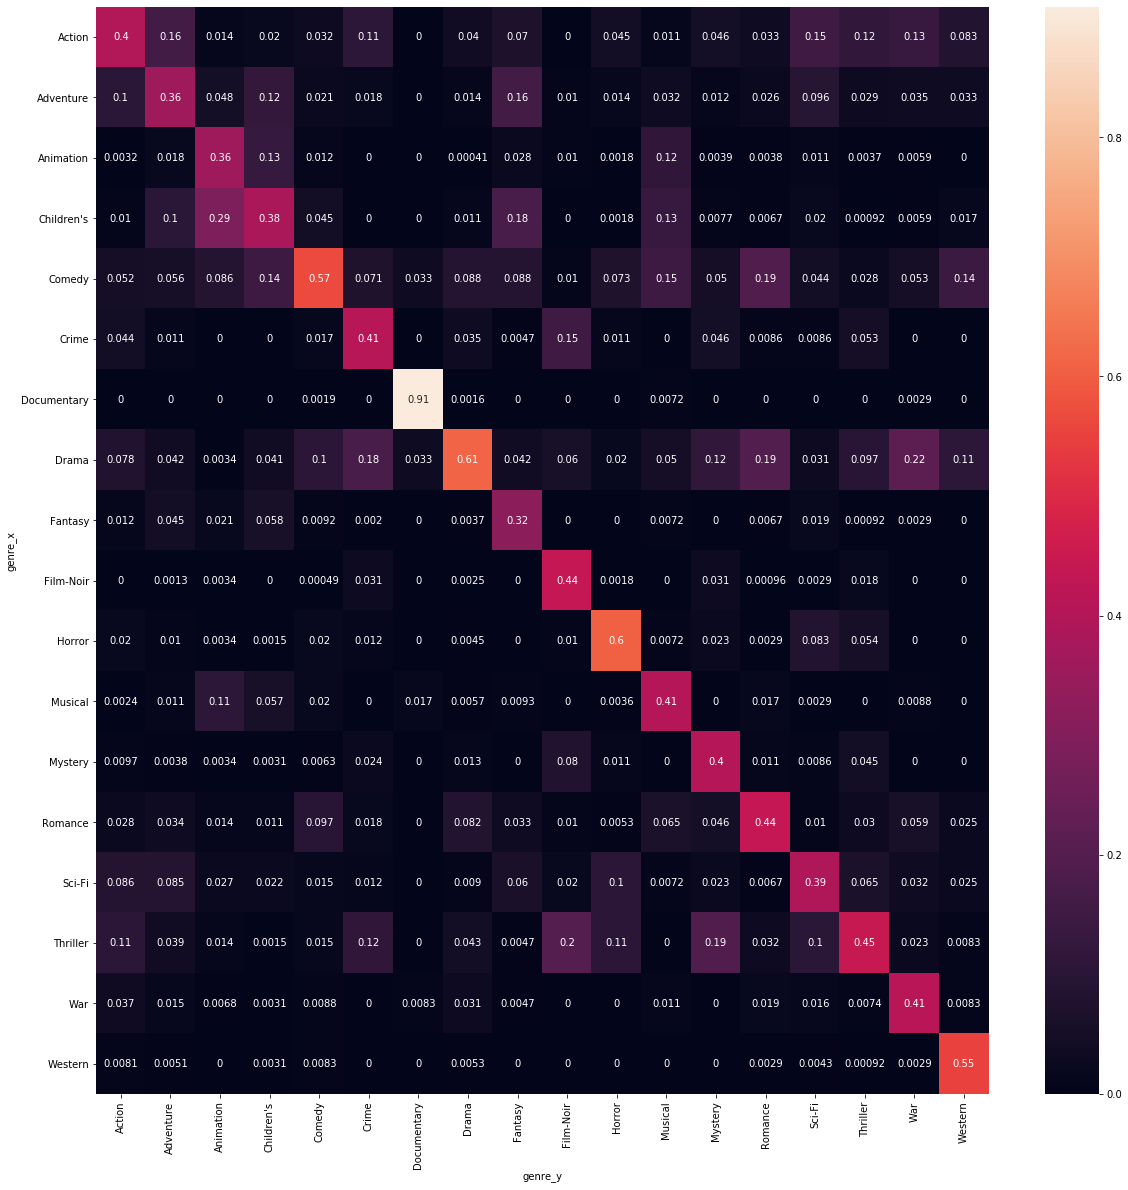

In [100]:
fig, ax = plt.subplots(figsize=(20,20)) 
ax = sns.heatmap(genre_adjacency_matrix1, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

* Several evaluations can be made of this genre-by-genre adjacency matrix. Here are example evaluations
    * In the thriller row, there is noticeable strength in association with Crime, Film Noir, Horror, and Mystery.
    * The documentary genre seems to be the most isolated genre. This could be logical, since documentaries tend to be non-fictional, compared to the other genre's.
    * Look at Animation and Children's movie. Notice that this matrix is not symmetrical. In the children's row, the association with Animation is noticeable at a strength of 0.29. But for the Animation's row, the association with Childrens is lesser than 0.29, at 0.13. You can evaluate this as: "A lot children's movies are animated, but not a lot of animated films are for children."  
* But we'd like to see ***indirect*** associations,  or "2nd-degree friends". This requires the matrix to be multiplied with itself. This allows you to see to see the "friends of the friends" of a given genre, and ultimately repeating this calculation will gradually reveal which "cliques" a genre is most clustered with.

In [106]:
genre_adjacency_matrix2 = genre_adjacency_matrix1 @ genre_adjacency_matrix1

In [107]:
genre_adjacency_matrix2 =genre_adjacency_matrix2.div(genre_adjacency_matrix2.sum(axis=1))

(18.0, 0)

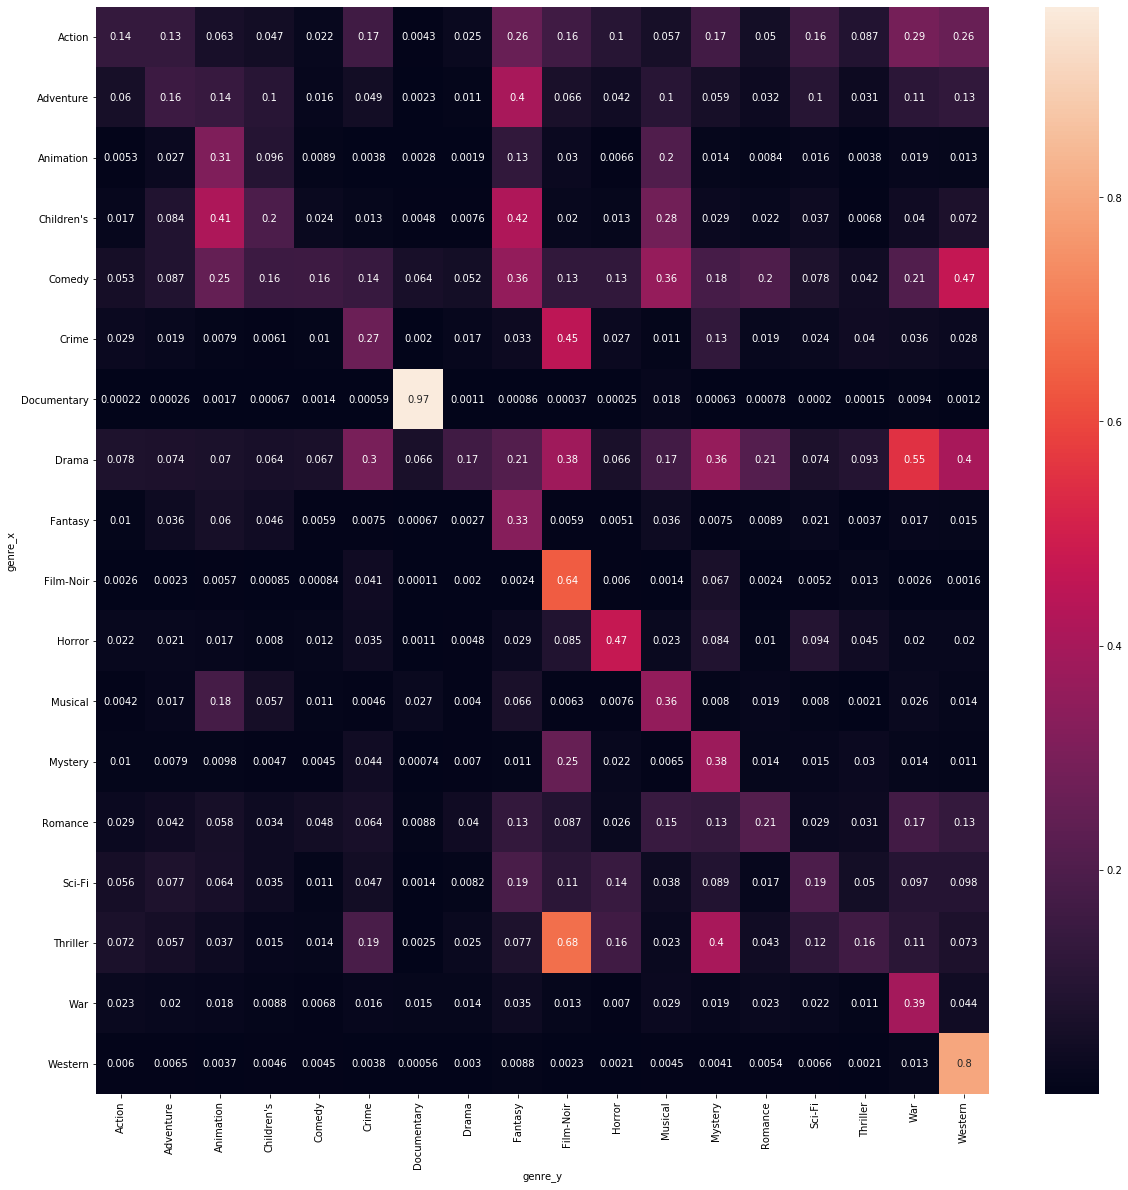

In [110]:
fig, ax = plt.subplots(figsize=(20,20)) 
ax = sns.heatmap(genre_adjacency_matrix2, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

(18.0, 0)

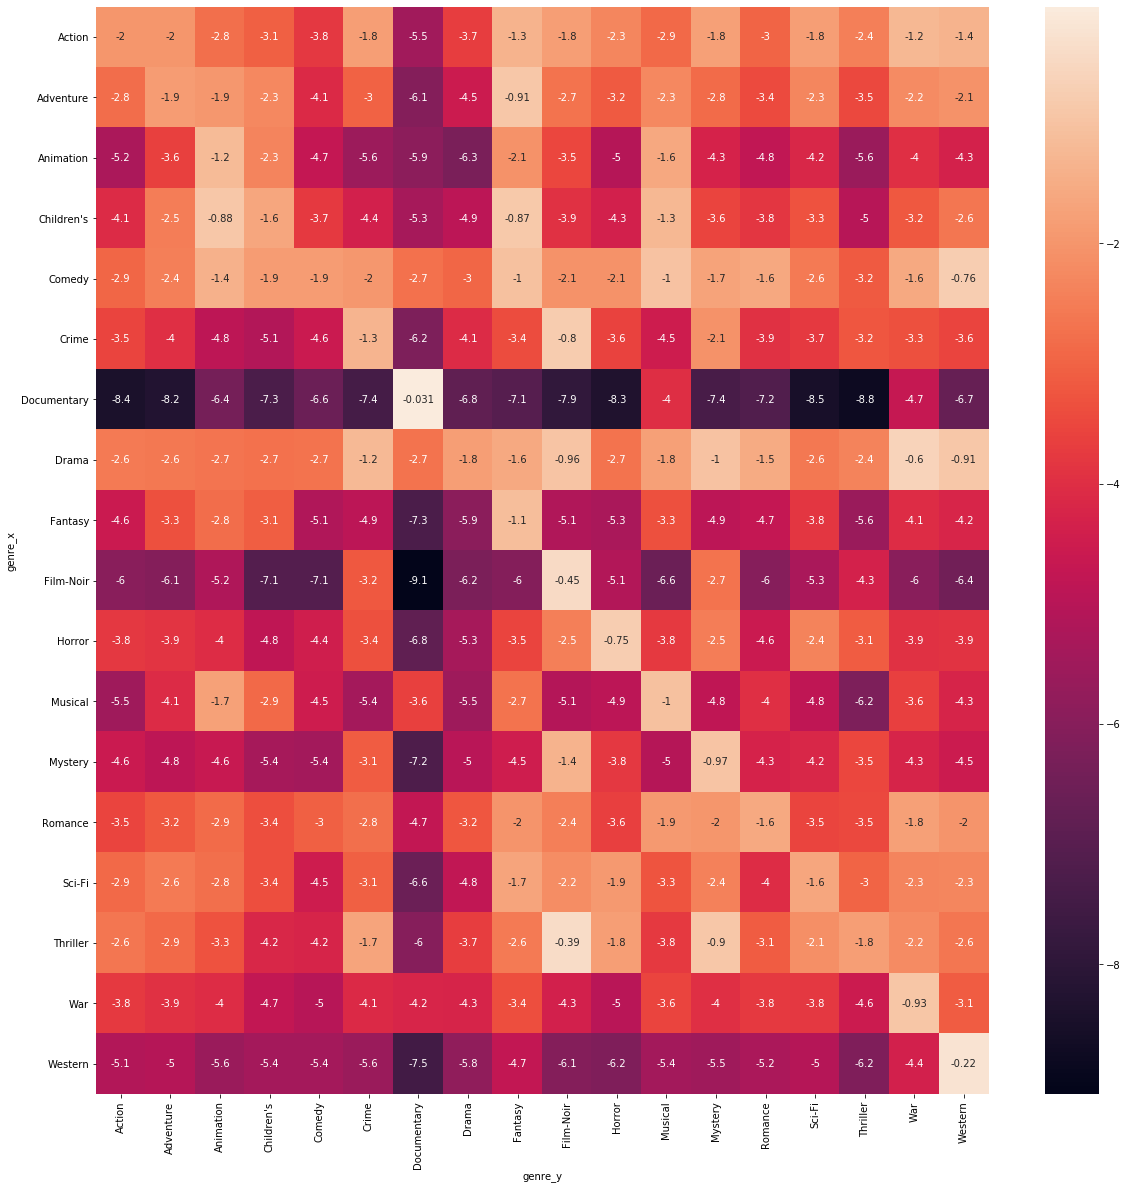

In [105]:
fig, ax = plt.subplots(figsize=(20,20)) 
ax = sns.heatmap(genre_adjacency_matrix2.apply(np.log), annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()
ax.set_ylim(sum(y_lims), 0)

* For this 2nd degree adjacency matrix, it can be logged to make comparisons easier. This could not be done with the original 1st degree adjacency matrix, which was full of zeros. 
* To evaluate this, it's easier to look at the genre's that AREN'T highly associated with others: These are documentaries, Westerns, and Film Noir.

## Predicting Movie Ratings

In [112]:
# https://machinelearningmastery.com/xgboost-for-regression/

## "Anti-recommendations"

In [198]:
data = data_orig

In [199]:
#Creating the rating matrix (rows as movies, columns as users)
ratings_mat = np.ndarray(
    shape=(np.max(data.movie_id.values), np.max(data.user_id.values)),
    dtype=np.uint8)
ratings_mat[data.movie_id.values-1, data.user_id.values-1] = data.rating.values

In [200]:
ratings_mat

array([[5, 0, 0, ..., 0, 0, 3],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [201]:
ratings_mat.shape # (Movies by users, 3952 by 6040)

(3952, 6040)

In [202]:
ratings_mat

#Normalizing the matrix(subtract mean off)
normalised_mat = ratings_mat - np.asarray([(np.mean(ratings_mat, 1))]).T # row wise mean subtraction

In [203]:
normalised_mat.T.shape # now, users by movies.

(6040, 3952)

In [204]:
np.sqrt(ratings_mat.shape[0] - 1)

62.85698051927089

In [205]:
A = normalised_mat.T / np.sqrt(ratings_mat.shape[0] - 1)

In [206]:
A.shape

(6040, 3952)

In [207]:
#Normalizing the matrix(subtract mean off)
normalised_mat = ratings_mat - np.asarray([(np.mean(ratings_mat, 1))]).T

#Computing the Singular Value Decomposition (SVD)
A = normalised_mat.T / np.sqrt(ratings_mat.shape[0] - 1)

In [194]:
#A = user_genre_rating_df1

In [208]:
U, S, V = np.linalg.svd(A)

In [209]:
#Function to calculate the cosine similarity (sorting by most similar and returning the top N)
def top_cosine_similarity(data, movie_id, top_n=10):
    index = movie_id - 1 # Movie id starts from 1 in the dataset
    movie_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

# Function to print top N similar movies
def print_similar_movies(movie_data, movie_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
    movie_data[movie_data.movie_id == movie_id].title.values[0]))
    for id_ in top_indexes + 1:
        print(movie_data[movie_data.movie_id == id_].title.values[0])

In [211]:
#k-principal components to represent movies, movie_id to find recommendations, top_n print n results        
k = 50
movie_id = 2355 # (getting an id from movies.dat)
top_n = 10
sliced = V.T[:, :k] # representative data
indexes = top_cosine_similarity(sliced, movie_id, top_n)

#Printing the top N similar movies
print_similar_movies(movie_data, movie_id, indexes)

Recommendations for Bug's Life, A (1998): 

Bug's Life, A (1998)
Toy Story 2 (1999)
Stuart Little (1999)
Iron Giant, The (1999)
Toy Story (1995)
Dinosaur (2000)
Prince of Egypt, The (1998)
Babe: Pig in the City (1998)
Babe (1995)
Tarzan (1999)


c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
